pymc.Mixtureを用いて潜在変数を積分消去

参考：https://www.pymc.io/projects/docs/en/stable/api/distributions/generated/pymc.Mixture.html

In [1]:
from scipy.stats import dirichlet
from scipy.special import kl_div
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from tslearn.datasets import CachedDatasets, UCR_UEA_datasets

import os

In [2]:
# データセット可視化メソッド
def plot_data(X_train, y_train, name):
    plt.figure(figsize=(12,5))

    # true
    # plt.subplot(1, 2, 1)
    label = np.unique(y_train)
    # カラーマップを定義
    cmap = plt.get_cmap('tab10')  # タブルランカラーマップを使用
    colors = [cmap(i) for i in range(len(label))]

    for class_label in label:
        class_data = X_train[y_train == class_label][:,:,0].T
        plt.plot(class_data, label=f'_Class {class_label}', color=colors[class_label - 1], alpha=0.4)
        plt.plot([], label=f'Class {class_label}', color=colors[class_label - 1], alpha=0.3)

    plt.legend()
    # plt.text(0.05,0.95,'pred', transform=plt.gca().transAxes)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title(f'{name}')

    plt.tight_layout()
    plt.show()

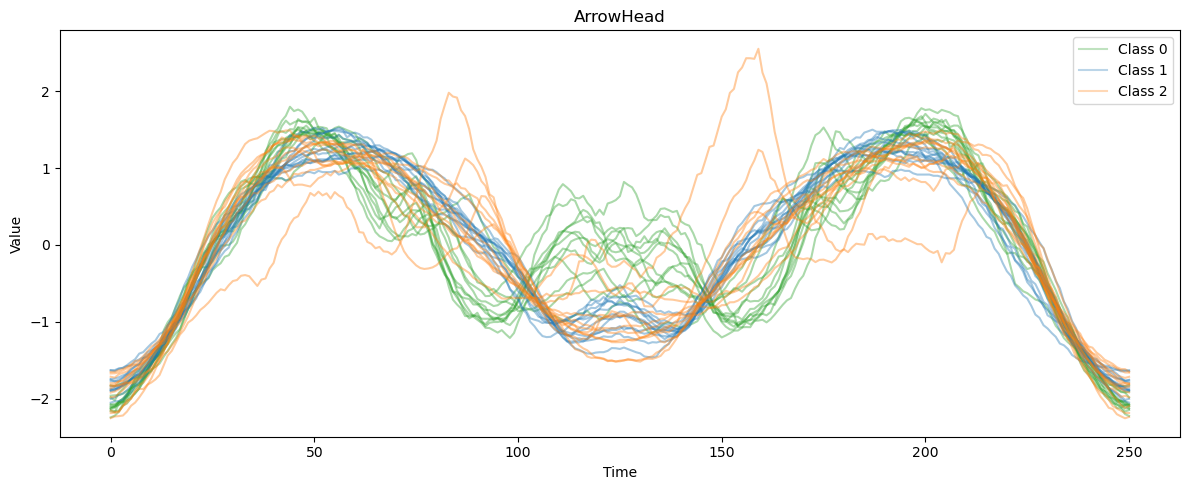

In [3]:
data_name = 'ArrowHead'

# データセットの読み込み（ここではUCR/UEAデータセットを使用）
X_train, y_train, X_test, y_test = UCR_UEA_datasets().load_dataset(data_name)

plot_data(X_train, y_train, data_name)

In [4]:
y_train

array([0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0,
       1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2])

trainデータの形状確認

In [5]:
X_train[:,:,0].shape

(36, 251)

trainデータのlabel_1の形状を変える

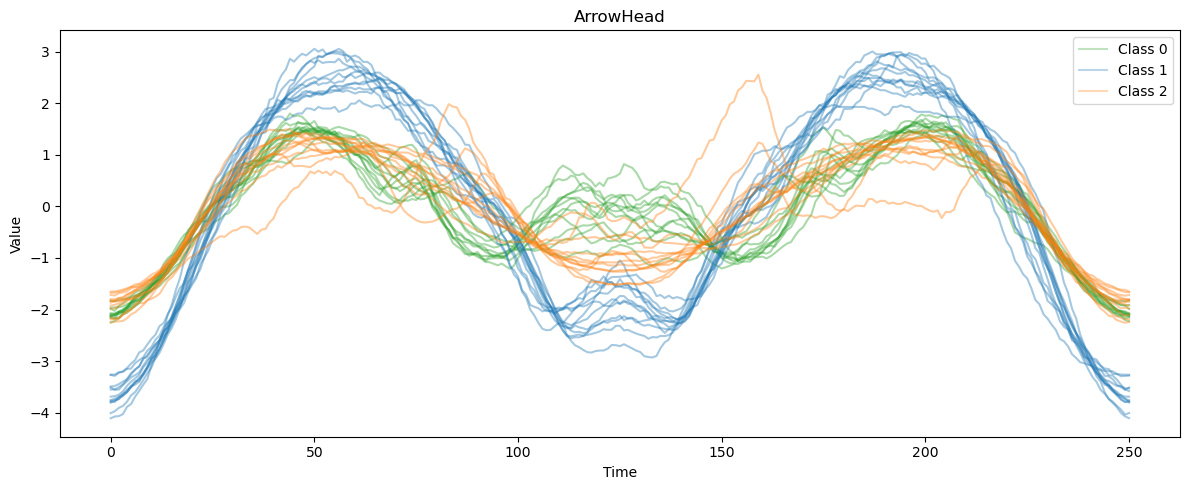

In [6]:
X_train[y_train==1] = X_train[y_train==1] * 2

plot_data(X_train, y_train, data_name)

trainデータ全体の頻度分布をからbinsの設定を取得

In [7]:
hist, bin_edges = np.histogram(X_train[:,:,0].T, bins='sturges', density=False)
print('hist:', hist,'\nbin_edges:', bin_edges)

bin_max = bin_edges.max()
bin_min = bin_edges.min()
bin_num = len(hist)

print('bin_max:', bin_max, '\nbin_min:', bin_min, '\nbin_num:', bin_num)

hist: [  63  133  123  232  615  599  926 1032 1010 1039 1209 1069  360  453
  173] 
bin_edges: [-4.1074854  -3.62999617 -3.15250695 -2.67501772 -2.19752849 -1.72003927
 -1.24255004 -0.76506081 -0.28757159  0.18991764  0.66740687  1.14489609
  1.62238532  2.09987455  2.57736377  3.054853  ]
bin_max: 3.054853 
bin_min: -4.1074854 
bin_num: 15


上記のbins設定でtraiｎデータ全体を頻度分布に変換

In [8]:
hist_li = []
for d in range(X_train.shape[0]):
    hist_ = np.histogram(X_train[d], bins=bin_num, range=(bin_min, bin_max), density=False)[0] + 0.000001
    hist_li.append(hist_ / hist_.sum()) # 合計を１にスケール

X_hist = np.array(hist_li)
X_hist

array([[3.98406351e-09, 3.98406351e-09, 3.98406351e-09, 3.98406351e-09,
        6.37450201e-02, 5.57768931e-02, 6.77290836e-02, 2.90836640e-01,
        6.77290836e-02, 1.43426290e-01, 1.23505973e-01, 1.87250989e-01,
        3.98406351e-09, 3.98406351e-09, 3.98406351e-09],
       [3.98406351e-09, 5.97609566e-02, 3.58565755e-02, 1.23505973e-01,
        7.96812741e-02, 4.38247026e-02, 4.78087661e-02, 3.98406391e-02,
        5.17928296e-02, 6.77290836e-02, 7.17131471e-02, 7.17131471e-02,
        7.96812741e-02, 1.79282862e-01, 4.78087661e-02],
       [3.98406351e-09, 3.98406351e-09, 3.98406351e-09, 3.98406351e-09,
        4.78087661e-02, 5.97609566e-02, 1.95219116e-01, 1.19521909e-01,
        1.11553782e-01, 1.19521909e-01, 1.59362544e-01, 1.87250989e-01,
        3.98406351e-09, 3.98406351e-09, 3.98406351e-09],
       [3.98406351e-09, 3.98406351e-09, 3.98406351e-09, 3.98406351e-09,
        6.77290836e-02, 4.38247026e-02, 1.23505973e-01, 1.51394417e-01,
        2.03187243e-01, 1.43426290e-0

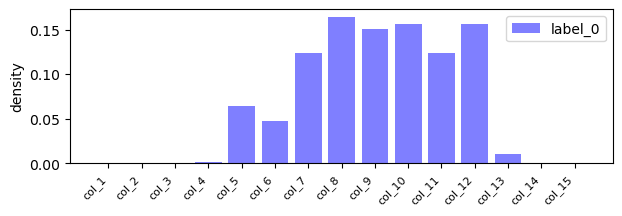

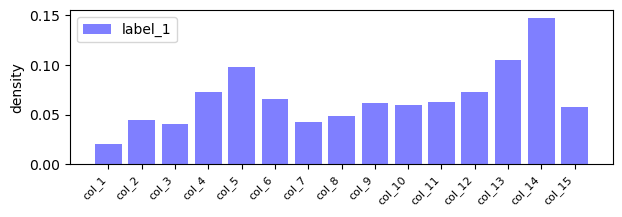

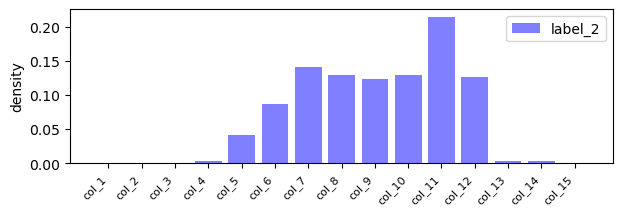

In [9]:
X_cols = [f'col_{i+1}' for i in range(X_hist.shape[1])]

for i in range(3):
    # ヒストグラムをプロット
    plt.figure(figsize=(7,2))
    plt.bar(X_cols, X_hist[y_train==i].mean(axis=0), color='blue', alpha=0.5, label=f'label_{i}')  # ヒストグラムを作成。binsはビンの数、alphaは透明度
    # plt.bar(X_cols, X_hist[y_train==1].mean(axis=0), color='red', alpha=0.5, label='label_1')
    # plt.bar(X_cols, X_hist[y_train==2].mean(axis=0), color='green', alpha=0.5, label='label_2')
    # plt.xlabel('')  # x軸ラベル
    plt.ylabel('density')  # y軸ラベル
    plt.title('')  # グラフタイトル
    plt.xticks(rotation=45, ha='right', fontsize=8)
    plt.legend()
    plt.show()  # グラフを表示

In [10]:
# CPU Multi
os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=8'

import jax
print(jax.default_backend())
print(jax.devices("cpu"))

cpu
[CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3), CpuDevice(id=4), CpuDevice(id=5), CpuDevice(id=6), CpuDevice(id=7)]


In [11]:
import pymc as pm
import arviz as az
print('version.', pm.__version__)
from pytensor import tensor as pt

version. 5.8.0


### 複数クラスに対するパラメータ推定

モデル定義

In [12]:
data_ = X_hist
data_

array([[3.98406351e-09, 3.98406351e-09, 3.98406351e-09, 3.98406351e-09,
        6.37450201e-02, 5.57768931e-02, 6.77290836e-02, 2.90836640e-01,
        6.77290836e-02, 1.43426290e-01, 1.23505973e-01, 1.87250989e-01,
        3.98406351e-09, 3.98406351e-09, 3.98406351e-09],
       [3.98406351e-09, 5.97609566e-02, 3.58565755e-02, 1.23505973e-01,
        7.96812741e-02, 4.38247026e-02, 4.78087661e-02, 3.98406391e-02,
        5.17928296e-02, 6.77290836e-02, 7.17131471e-02, 7.17131471e-02,
        7.96812741e-02, 1.79282862e-01, 4.78087661e-02],
       [3.98406351e-09, 3.98406351e-09, 3.98406351e-09, 3.98406351e-09,
        4.78087661e-02, 5.97609566e-02, 1.95219116e-01, 1.19521909e-01,
        1.11553782e-01, 1.19521909e-01, 1.59362544e-01, 1.87250989e-01,
        3.98406351e-09, 3.98406351e-09, 3.98406351e-09],
       [3.98406351e-09, 3.98406351e-09, 3.98406351e-09, 3.98406351e-09,
        6.77290836e-02, 4.38247026e-02, 1.23505973e-01, 1.51394417e-01,
        2.03187243e-01, 1.43426290e-0

In [13]:
data_.sum()

36.0

In [32]:
X_cols = [f'col_{i+1}' for i in range(data_.shape[1])]

K = 2

# モデルの定義
with pm.Model() as model_dirichlet:
    # coords(次元やインデックスを定義)
    model_dirichlet.add_coord('data', values=range(data_.shape[0]), mutable=True)
    model_dirichlet.add_coord('var', values=X_cols, mutable=True)
    model_dirichlet.add_coord('K', values=range(K), mutable=True)

    # 説明変数
    x = pm.MutableData('x', data_, dims=('data','var'))

    # 混合比の生成
    a = pm.Gamma('a', 20, 1)
    # a = pm.Uniform('a', lower=0.00001, upper=1)
    w = pm.StickBreakingWeights('w', alpha=a, K=K-1, dims=('K',))

    # 推論パラメータの事前分布
    alpha_ = pm.HalfNormal('alpha', dims=('K','var'), sigma=100)
    # Dirichlet分布
    components = pm.Dirichlet.dist(a=alpha_, shape=(K,len(X_cols)))
    result = pm.Mixture('obs', w=w, comp_dists=components, observed=x, dims=('data','var'))


# 定義した各パラメータの情報
display(model_dirichlet.model)

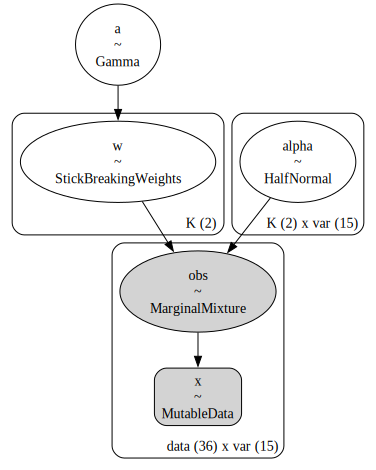

In [33]:
# 構造
modeldag = pm.model_to_graphviz(model_dirichlet)
display(modeldag)


In [34]:
model_dirichlet.debug()

point={'a_log__': array(2.99573227), 'w_simplex__': array([-1.49786614]), 'alpha_log__': array([[4.60517019, 4.60517019, 4.60517019, 4.60517019, 4.60517019,
        4.60517019, 4.60517019, 4.60517019, 4.60517019, 4.60517019,
        4.60517019, 4.60517019, 4.60517019, 4.60517019, 4.60517019],
       [4.60517019, 4.60517019, 4.60517019, 4.60517019, 4.60517019,
        4.60517019, 4.60517019, 4.60517019, 4.60517019, 4.60517019,
        4.60517019, 4.60517019, 4.60517019, 4.60517019, 4.60517019]])}

No problems found


In [35]:
%%time
# MCMC実行
# バックエンドでNumPyroで実行
with model_dirichlet:
    # MCMCによる推論
    trace = pm.sample(draws=3000, tune=1000, chains=1, nuts_sampler="numpyro", 
                        random_seed=1, return_inferencedata=True,)
# >> Wall time: 45.5 s
# データの保存 to_netcdfの利用
# trace.to_netcdf('model_random1.nc')
# データの読み込み from_netcdfの利用
#trace = az.from_netcdf('model_random1.nc')

/Users/tomokazu/miniforge3/envs/pymc/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Compiling...
Compilation time =  0:00:01.845165
Sampling...


sample: 100%|██████████| 4000/4000 [00:02<00:00, 1680.15it/s, 15 steps of size 1.95e-01. acc. prob=0.96]


Sampling time =  0:00:03.995864
Transforming variables...
Transformation time =  0:00:00.086793
CPU times: user 5.41 s, sys: 214 ms, total: 5.63 s
Wall time: 6.93 s


潜在変数を積分消去したので、numpyroでサンプリングできた

サンプラーが異なるので、ガンマ分布のパラメータを修正しないと、BinaryGibbsMetropolisと同じような結果が得られなかった

In [38]:
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

Max rhat: nan


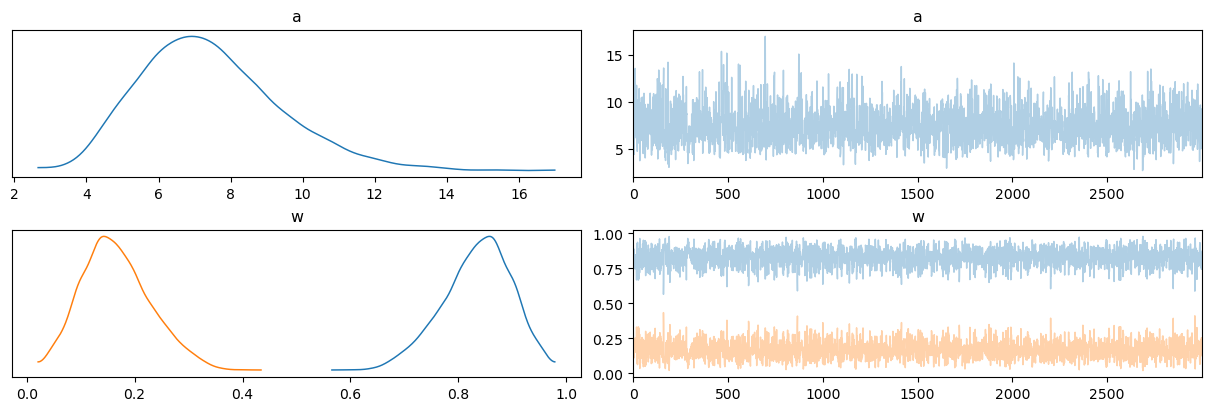

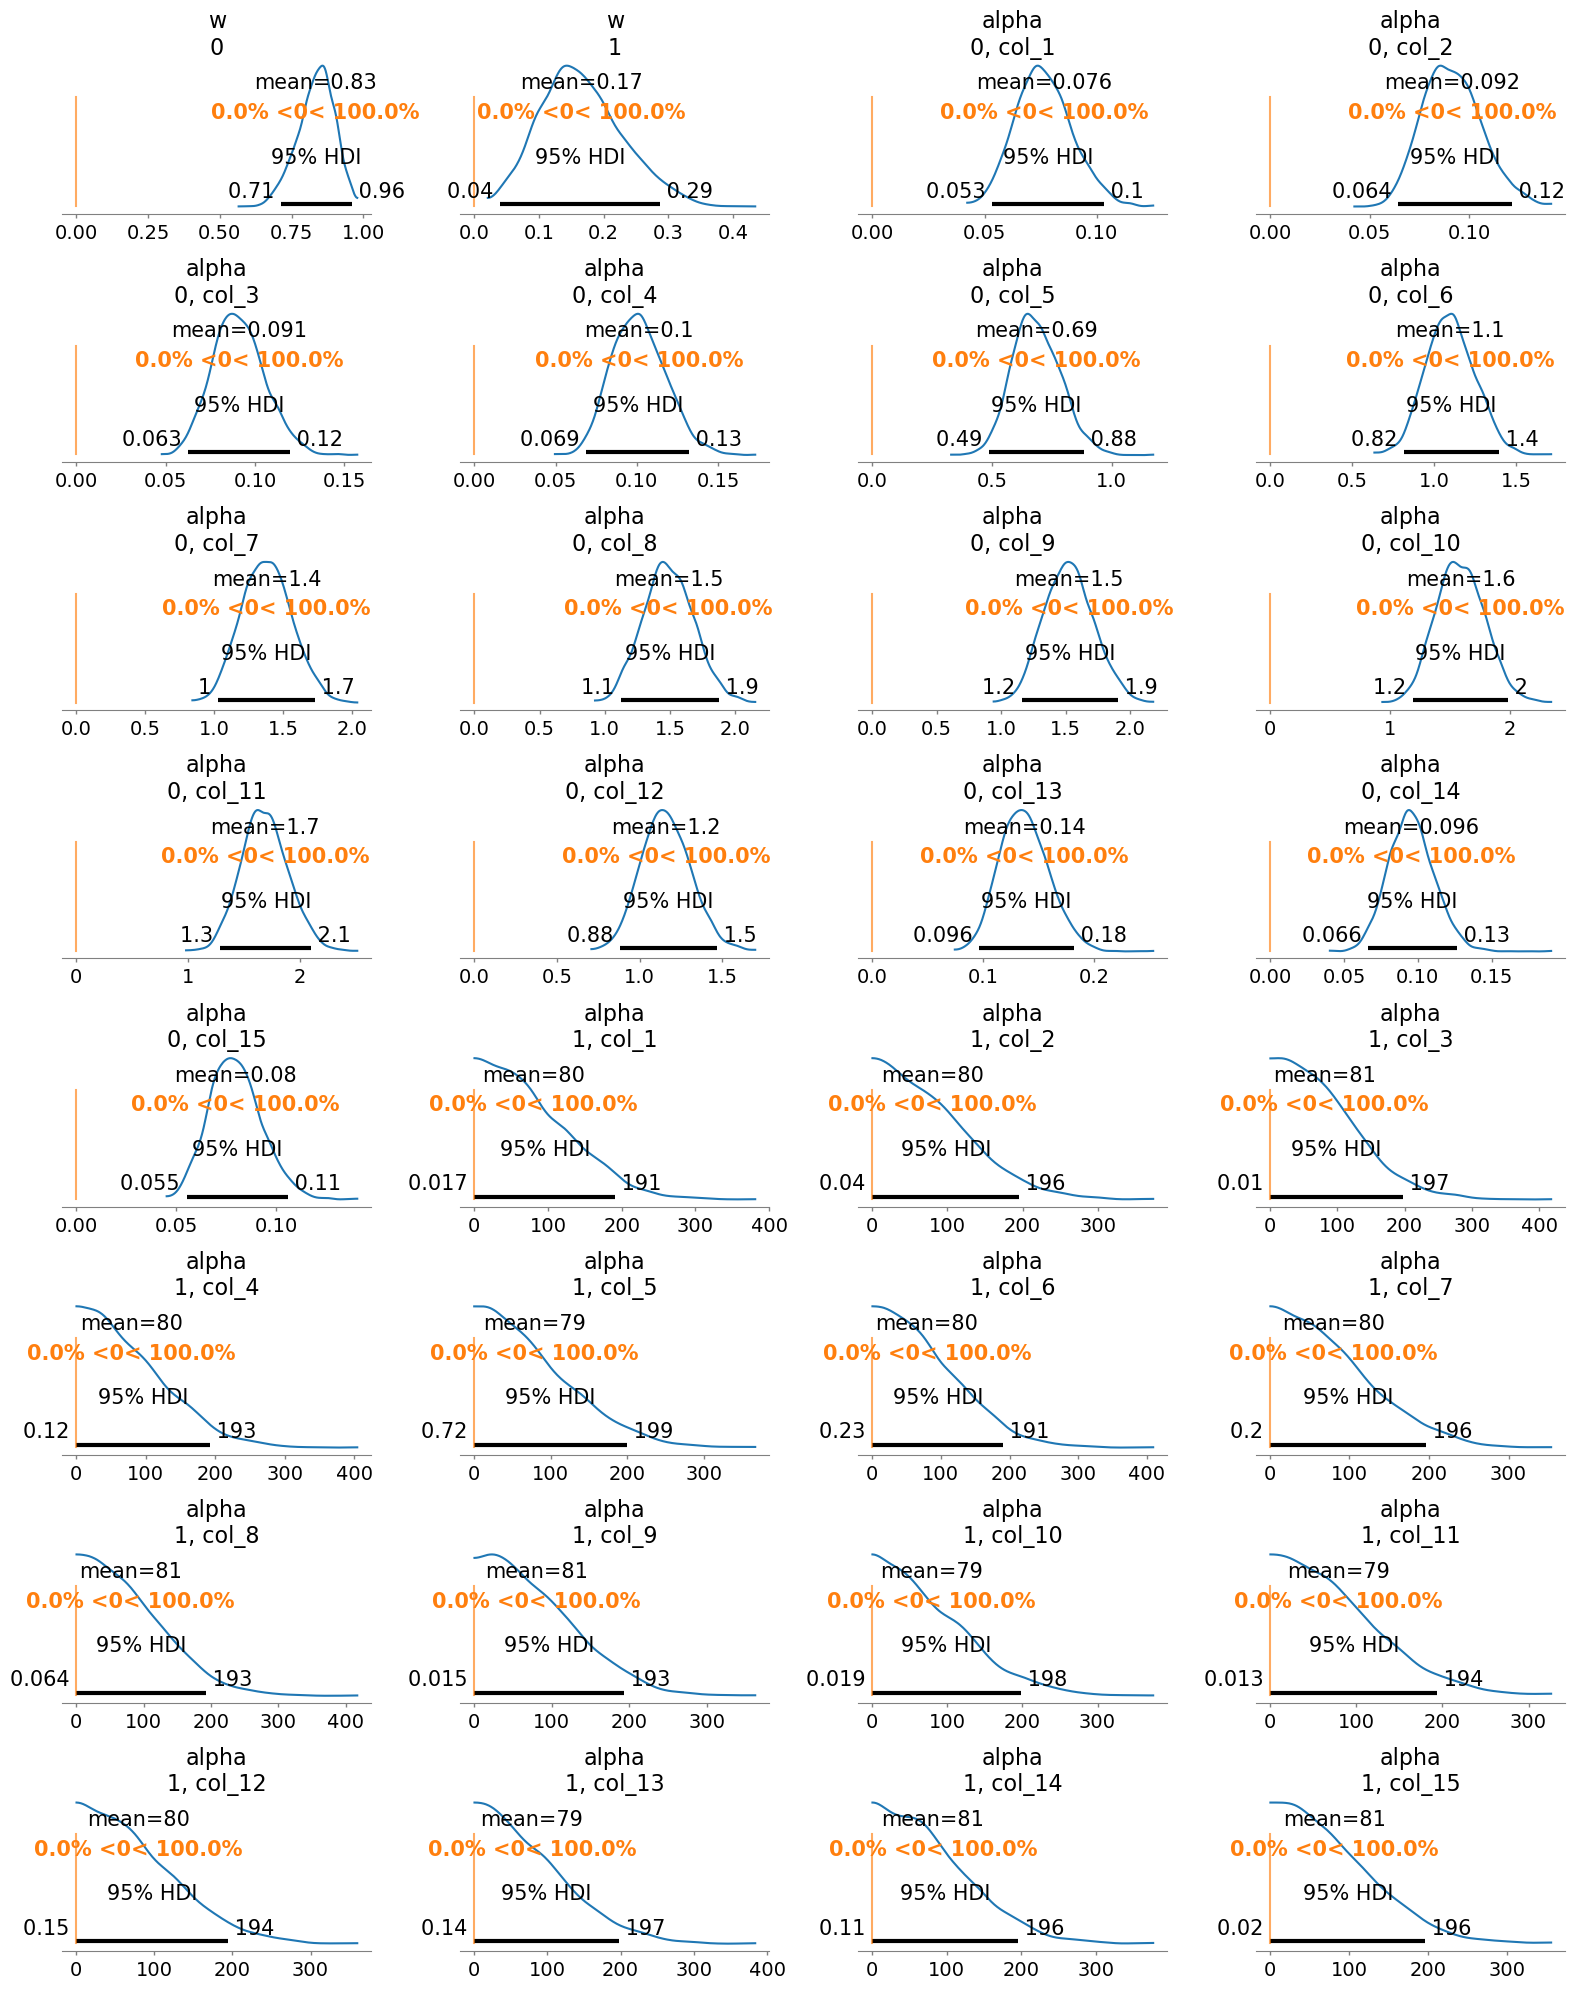

In [40]:
# MCMCの収束を評価
rhat_vals = az.rhat(trace).values()
# 最大のRhatを確認
result = np.max([np.max(i.values) for i in rhat_vals if i.name in ['w']])
print('Max rhat:', result)
# 1.1以上のRhatを確認
for i in rhat_vals:
    if np.max(i.values)>=1.1:
        print(i.name, np.max(i.values), np.mean(i.values), i.values.shape, sep='  ====>  ')


# トレースプロットとか
# plot_trace
az.plot_trace(trace, backend_kwargs={"constrained_layout":True}, var_names=['a','w'])
plt.show()

# # forest plotでRハットと一緒に可視化
# az.plot_forest(trace, combined=True, hdi_prob=0.95, r_hat=True, var_names=["coef", "intercept", "random", 'mu'])
# plt.tight_layout()
# plt.show()

# 事後分布の確認
az.plot_posterior(trace, hdi_prob=0.95, var_names=['w', 'alpha'], ref_val=0, figsize=(16,20))
plt.tight_layout()
plt.show()

# # Energy Plot
# az.plot_energy(trace)
# plt.show()


サンプリングされたラベルデータを観察

In [43]:
trace.posterior.w[0].shape

(3000, 2)

In [44]:
trace.posterior.w[0]

<xarray.DataArray 'w' (draw: 3000, K: 2)>
array([[0.70236421, 0.29763579],
       [0.86831503, 0.13168497],
       [0.82017168, 0.17982832],
       ...,
       [0.8665159 , 0.1334841 ],
       [0.74485451, 0.25514549],
       [0.85664154, 0.14335846]])
Coordinates:
    chain    int64 0
  * draw     (draw) int64 0 1 2 3 4 5 6 7 ... 2993 2994 2995 2996 2997 2998 2999
  * K        (K) int64 0 1

In [48]:
trace.posterior.w[0].mean(axis=0)

<xarray.DataArray 'w' (K: 2)>
array([0.8339288, 0.1660712])
Coordinates:
    chain    int64 0
  * K        (K) int64 0 1

頻度分布が大きく異なる場合はちゃんと検出できている

パラメータalphaのサンプリングを確認

In [49]:
# 各パラメータの事後分布の確認・評価（統計量）
df_summary = pm.summary(trace)
# df_summary['alpha_normal'] = df_summary['mean'] / df_summary['mean'].sum()
# df_summary['alpha_normal']
df_summary

arviz - WARNING - Shape validation failed: input_shape: (1, 3000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,7.425,1.933,4.063,10.959,0.041,0.029,2080.0,1941.0,NaN
w[0],0.834,0.064,0.715,0.953,0.001,0.001,2108.0,1704.0,NaN
w[1],0.166,0.064,0.047,0.285,0.001,0.001,2108.0,1704.0,NaN
"alpha[0, col_1]",0.076,0.013,0.054,0.102,0.000,0.000,2565.0,2140.0,NaN
"alpha[0, col_2]",0.092,0.015,0.064,0.119,0.000,0.000,2908.0,2428.0,NaN
"alpha[0, col_3]",0.091,0.015,0.063,0.117,0.000,0.000,2216.0,2077.0,NaN
"alpha[0, col_4]",0.101,0.017,0.072,0.132,0.000,0.000,2142.0,2062.0,NaN
"alpha[0, col_5]",0.686,0.101,0.491,0.866,0.002,0.001,2707.0,1549.0,NaN
"alpha[0, col_6]",1.098,0.151,0.828,1.378,0.003,0.002,2646.0,2238.0,NaN
"alpha[0, col_7]",1.379,0.183,1.049,1.729,0.004,0.003,2097.0,2227.0,NaN


In [50]:
df_a0 = df_summary.loc[[ind for ind in df_summary.index if 'alpha[0,' in ind]]
df_a0['alpha_normal'] = df_a0['mean'] / df_a0['mean'].sum()
print(df_a0['alpha_normal'].sum())

df_a1 = df_summary.loc[[ind for ind in df_summary.index if 'alpha[1,' in ind]]
df_a1['alpha_normal'] = df_a1['mean'] / df_a1['mean'].sum()
print(df_a1['alpha_normal'].sum())

1.0
1.0000000000000002


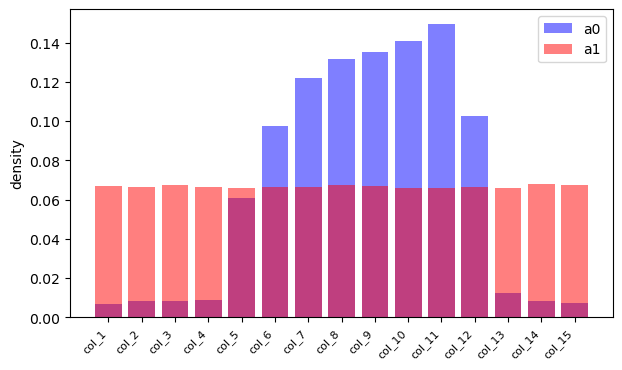

In [51]:
# ヒストグラムをプロット
plt.figure(figsize=(7,4))
plt.bar(X_cols, df_a0['alpha_normal'].values, color='blue', alpha=0.5, label='a0')  # ヒストグラムを作成。binsはビンの数、alphaは透明度
plt.bar(X_cols, df_a1['alpha_normal'].values, color='red', alpha=0.5, label='a1')
# plt.xlabel('')  # x軸ラベル
plt.ylabel('density')  # y軸ラベル
plt.title('')  # グラフタイトル
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.legend()
plt.show()  # グラフを表示

# Automatic Differentiation Variational Inference (ADVI)で推論

潜在変数を積分消去しているので、ADVIが使用できる（カテゴリー変数＝離散変数があると使用できない）

参考：https://learning-with-machine.hatenablog.com/entry/2020/03/26/212328#ADVIによる推論

In [55]:
X_cols = [f'col_{i+1}' for i in range(data_.shape[1])]

K = 2

# モデルの定義
with pm.Model() as model_dirichlet:
    # coords(次元やインデックスを定義)
    model_dirichlet.add_coord('data', values=range(data_.shape[0]), mutable=True)
    model_dirichlet.add_coord('var', values=X_cols, mutable=True)
    model_dirichlet.add_coord('K', values=range(K), mutable=True)

    # 説明変数
    x = pm.MutableData('x', data_, dims=('data','var'))

    # 混合比の生成
    a = pm.Gamma('a', 20, 1)
    # a = pm.Uniform('a', lower=0.00001, upper=1)
    w = pm.StickBreakingWeights('w', alpha=a, K=K-1, dims=('K',))

    # 推論パラメータの事前分布
    alpha_ = pm.HalfNormal('alpha', dims=('K','var'), sigma=100)
    # Dirichlet分布
    components = pm.Dirichlet.dist(a=alpha_, shape=(K,len(X_cols)))
    result = pm.Mixture('obs', w=w, comp_dists=components, observed=x, dims=('data','var'))


# 定義した各パラメータの情報
display(model_dirichlet.model)

In [56]:
%%time
# MCMC実行
# バックエンドでNumPyroで実行
with model_dirichlet:
    # ADVIによる推論
    approx = pm.fit(n=10000, obj_optimizer=pm.adagrad(learning_rate=1e-1),
                    method='advi', random_seed=1)

Finished [100%]: Average Loss = -1,426.6


CPU times: user 1.86 s, sys: 102 ms, total: 1.96 s
Wall time: 3.01 s


In [70]:
approx.hist

array([253885.28675579, 186127.39906151, 199894.52432334, ...,
        -1737.41062414,  -1619.1421968 ,  -1537.6319984 ])

Text(0, 0.5, 'ELBO')

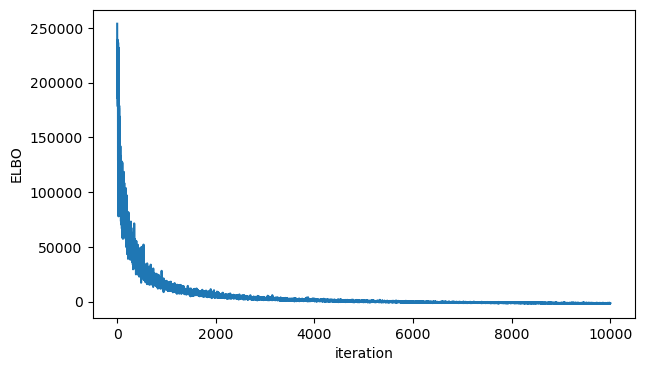

In [72]:
# ELBOをプロット
fig = plt.figure(figsize=(7, 4))
ax = fig.subplots(1,1)

ax.plot(approx.hist)
ax.set_xlabel('iteration')
ax.set_ylabel('ELBO')

変分法で推定した近似分布からパラメータの値をサンプリングする

In [76]:
# 事後分布からのサンプリング
sample_post_advi = approx.sample(1000, random_seed=1)
sample_post_advi


Inference data with groups:
	> posterior
	> observed_data
	> constant_data

In [77]:
df_summary_advi = pm.summary(sample_post_advi)
df_summary_advi

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,7.309,1.641,4.082,10.131,0.058,0.042,808.0,823.0,NaN
w[0],0.834,0.058,0.725,0.932,0.002,0.001,894.0,815.0,NaN
w[1],0.166,0.058,0.068,0.275,0.002,0.001,894.0,815.0,NaN
"alpha[0, col_1]",0.571,0.135,0.332,0.827,0.004,0.003,980.0,945.0,NaN
"alpha[0, col_2]",0.690,0.227,0.327,1.130,0.007,0.005,990.0,802.0,NaN
"alpha[0, col_3]",0.725,0.198,0.364,1.069,0.006,0.005,942.0,817.0,NaN
"alpha[0, col_4]",0.849,0.234,0.464,1.276,0.007,0.005,1007.0,847.0,NaN
"alpha[0, col_5]",2.391,0.750,1.221,3.813,0.025,0.017,938.0,983.0,NaN
"alpha[0, col_6]",3.180,0.518,2.195,4.132,0.016,0.012,1001.0,944.0,NaN
"alpha[0, col_7]",3.965,0.408,3.260,4.783,0.014,0.010,874.0,946.0,NaN


In [78]:
df_a0_advi = df_summary_advi.loc[[ind for ind in df_summary_advi.index if 'alpha[0,' in ind]]
df_a0_advi['alpha_normal'] = df_a0_advi['mean'] / df_a0_advi['mean'].sum()
print(df_a0_advi['alpha_normal'].sum())

df_a1_advi = df_summary_advi.loc[[ind for ind in df_summary_advi.index if 'alpha[1,' in ind]]
df_a1_advi['alpha_normal'] = df_a1_advi['mean'] / df_a1_advi['mean'].sum()
print(df_a1_advi['alpha_normal'].sum())

1.0000000000000002
1.0000000000000002


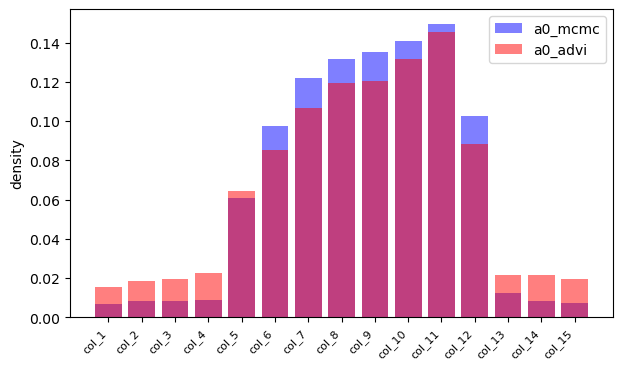

In [80]:
# ヒストグラムをプロット
plt.figure(figsize=(7,4))
plt.bar(X_cols, df_a0['alpha_normal'].values, color='blue', alpha=0.5, label='a0_mcmc')  # ヒストグラムを作成。binsはビンの数、alphaは透明度
plt.bar(X_cols, df_a0_advi['alpha_normal'].values, color='red', alpha=0.5, label='a0_advi')
# plt.xlabel('')  # x軸ラベル
plt.ylabel('density')  # y軸ラベル
plt.title('')  # グラフタイトル
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.legend()
plt.show()  # グラフを表示

## FullRankADVIで推定

In [92]:
X_cols = [f'col_{i+1}' for i in range(data_.shape[1])]

K = 2

# モデルの定義
with pm.Model() as model_dirichlet:
    # coords(次元やインデックスを定義)
    model_dirichlet.add_coord('data', values=range(data_.shape[0]), mutable=True)
    model_dirichlet.add_coord('var', values=X_cols, mutable=True)
    model_dirichlet.add_coord('K', values=range(K), mutable=True)

    # 説明変数
    x = pm.MutableData('x', data_, dims=('data','var'))

    # 混合比の生成
    a = pm.Gamma('a', 20, 1)
    # a = pm.Uniform('a', lower=0.00001, upper=1)
    w = pm.StickBreakingWeights('w', alpha=a, K=K-1, dims=('K',))

    # 推論パラメータの事前分布
    alpha_ = pm.HalfNormal('alpha', dims=('K','var'), sigma=100)
    # Dirichlet分布
    components = pm.Dirichlet.dist(a=alpha_, shape=(K,len(X_cols)))
    result = pm.Mixture('obs', w=w, comp_dists=components, observed=x, dims=('data','var'))


# 定義した各パラメータの情報
display(model_dirichlet.model)

In [105]:
%%time
# MCMC実行
# バックエンドでNumPyroで実行
with model_dirichlet:
    # ADVIによる推論
    approx = pm.fit(n=10000, obj_optimizer=pm.adagrad(learning_rate=1e-1),
                    method='fullrank_advi', random_seed=1)

Finished [100%]: Average Loss = 1,695.9


CPU times: user 2.21 s, sys: 46.9 ms, total: 2.26 s
Wall time: 2.29 s


Text(0, 0.5, 'ELBO')

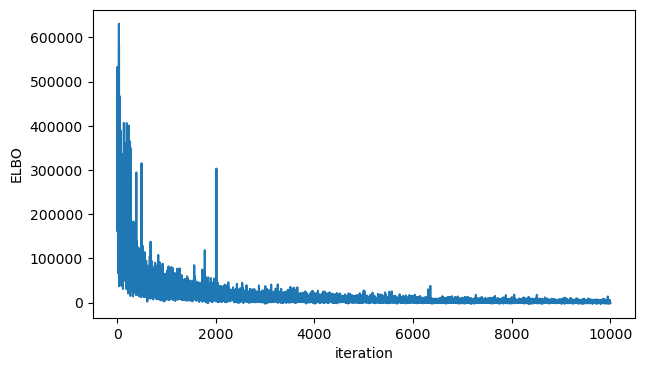

In [106]:
# ELBOをプロット
fig = plt.figure(figsize=(7, 4))
ax = fig.subplots(1,1)

ax.plot(approx.hist)
ax.set_xlabel('iteration')
ax.set_ylabel('ELBO')

In [107]:
# 事後分布からのサンプリング
sample_post_advi = approx.sample(1000, random_seed=1)
sample_post_advi

df_summary_advi = pm.summary(sample_post_advi)
df_summary_advi

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,9.438,2.316,5.668,13.888,0.072,0.051,999.0,936.0,NaN
w[0],0.688,0.126,0.452,0.906,0.004,0.003,1111.0,983.0,NaN
w[1],0.312,0.126,0.094,0.548,0.004,0.003,1111.0,983.0,NaN
"alpha[0, col_1]",1.437,0.714,0.399,2.757,0.022,0.015,1080.0,1059.0,NaN
"alpha[0, col_2]",2.792,2.565,0.097,7.227,0.084,0.061,1005.0,880.0,NaN
"alpha[0, col_3]",1.710,1.077,0.310,3.756,0.034,0.024,963.0,932.0,NaN
"alpha[0, col_4]",2.350,1.587,0.362,5.009,0.054,0.038,917.0,833.0,NaN
"alpha[0, col_5]",4.916,2.906,0.982,10.114,0.092,0.065,982.0,903.0,NaN
"alpha[0, col_6]",10.085,6.192,1.981,21.347,0.195,0.138,970.0,980.0,NaN
"alpha[0, col_7]",10.832,5.026,3.385,19.802,0.153,0.108,1044.0,911.0,NaN


In [108]:
df_a0_advi = df_summary_advi.loc[[ind for ind in df_summary_advi.index if 'alpha[0,' in ind]]
df_a0_advi['alpha_normal'] = df_a0_advi['mean'] / df_a0_advi['mean'].sum()
print(df_a0_advi['alpha_normal'].sum())

df_a1_advi = df_summary_advi.loc[[ind for ind in df_summary_advi.index if 'alpha[1,' in ind]]
df_a1_advi['alpha_normal'] = df_a1_advi['mean'] / df_a1_advi['mean'].sum()
print(df_a1_advi['alpha_normal'].sum())

0.9999999999999999
1.0000000000000004


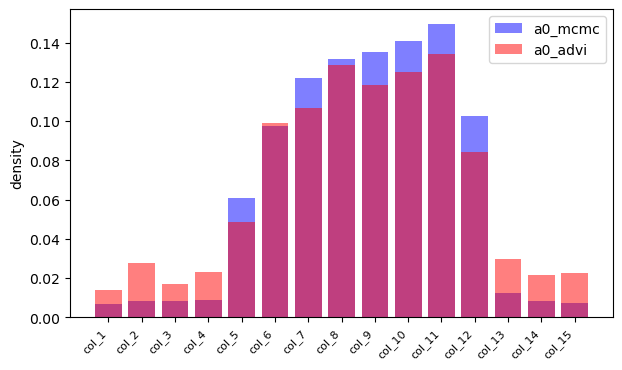

In [109]:
# ヒストグラムをプロット
plt.figure(figsize=(7,4))
plt.bar(X_cols, df_a0['alpha_normal'].values, color='blue', alpha=0.5, label='a0_mcmc')  # ヒストグラムを作成。binsはビンの数、alphaは透明度
plt.bar(X_cols, df_a0_advi['alpha_normal'].values, color='red', alpha=0.5, label='a0_advi')
# plt.xlabel('')  # x軸ラベル
plt.ylabel('density')  # y軸ラベル
plt.title('')  # グラフタイトル
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.legend()
plt.show()  # グラフを表示

普通のADVIの方が推定結果が良好

## ADVIでサンプリング数を増やす

In [112]:
X_cols = [f'col_{i+1}' for i in range(data_.shape[1])]

K = 2

# モデルの定義
with pm.Model() as model_dirichlet:
    # coords(次元やインデックスを定義)
    model_dirichlet.add_coord('data', values=range(data_.shape[0]), mutable=True)
    model_dirichlet.add_coord('var', values=X_cols, mutable=True)
    model_dirichlet.add_coord('K', values=range(K), mutable=True)

    # 説明変数
    x = pm.MutableData('x', data_, dims=('data','var'))

    # 混合比の生成
    a = pm.Gamma('a', 20, 1)
    # a = pm.Uniform('a', lower=0.00001, upper=1)
    w = pm.StickBreakingWeights('w', alpha=a, K=K-1, dims=('K',))

    # 推論パラメータの事前分布
    alpha_ = pm.HalfNormal('alpha', dims=('K','var'), sigma=100)
    # Dirichlet分布
    components = pm.Dirichlet.dist(a=alpha_, shape=(K,len(X_cols)))
    result = pm.Mixture('obs', w=w, comp_dists=components, observed=x, dims=('data','var'))


# 定義した各パラメータの情報
display(model_dirichlet.model)

In [113]:
%%time
# MCMC実行
# バックエンドでNumPyroで実行
with model_dirichlet:
    # ADVIによる推論
    approx = pm.fit(n=100000, obj_optimizer=pm.adagrad(learning_rate=1e-1),
                    method='advi', random_seed=1)

Finished [100%]: Average Loss = -2,799.1


CPU times: user 9.76 s, sys: 604 ms, total: 10.4 s
Wall time: 10 s


Text(0, 0.5, 'ELBO')

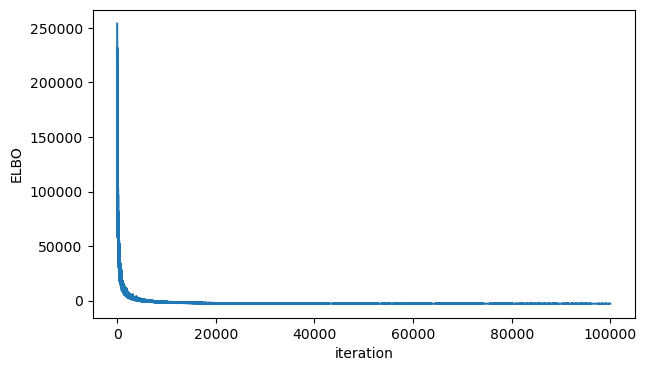

In [114]:
# ELBOをプロット
fig = plt.figure(figsize=(7, 4))
ax = fig.subplots(1,1)

ax.plot(approx.hist)
ax.set_xlabel('iteration')
ax.set_ylabel('ELBO')

In [115]:
# 事後分布からのサンプリング
sample_post_advi = approx.sample(1000, random_seed=1)
sample_post_advi

df_summary_advi = pm.summary(sample_post_advi)
df_summary_advi

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,7.442,1.740,4.581,10.773,0.054,0.039,999.0,936.0,NaN
w[0],0.836,0.057,0.729,0.931,0.002,0.001,1123.0,963.0,NaN
w[1],0.164,0.057,0.069,0.271,0.002,0.001,1123.0,963.0,NaN
"alpha[0, col_1]",0.099,0.019,0.067,0.136,0.001,0.000,1092.0,1024.0,NaN
"alpha[0, col_2]",0.121,0.029,0.064,0.172,0.001,0.001,1003.0,906.0,NaN
"alpha[0, col_3]",0.123,0.025,0.081,0.172,0.001,0.001,950.0,906.0,NaN
"alpha[0, col_4]",0.140,0.031,0.086,0.196,0.001,0.001,984.0,920.0,NaN
"alpha[0, col_5]",0.723,0.159,0.466,1.037,0.005,0.004,1009.0,721.0,NaN
"alpha[0, col_6]",1.154,0.151,0.905,1.441,0.005,0.003,958.0,905.0,NaN
"alpha[0, col_7]",1.470,0.168,1.155,1.774,0.005,0.004,1047.0,941.0,NaN


In [116]:
df_a0_advi = df_summary_advi.loc[[ind for ind in df_summary_advi.index if 'alpha[0,' in ind]]
df_a0_advi['alpha_normal'] = df_a0_advi['mean'] / df_a0_advi['mean'].sum()
print(df_a0_advi['alpha_normal'].sum())

df_a1_advi = df_summary_advi.loc[[ind for ind in df_summary_advi.index if 'alpha[1,' in ind]]
df_a1_advi['alpha_normal'] = df_a1_advi['mean'] / df_a1_advi['mean'].sum()
print(df_a1_advi['alpha_normal'].sum())

0.9999999999999997
1.0000000000000002


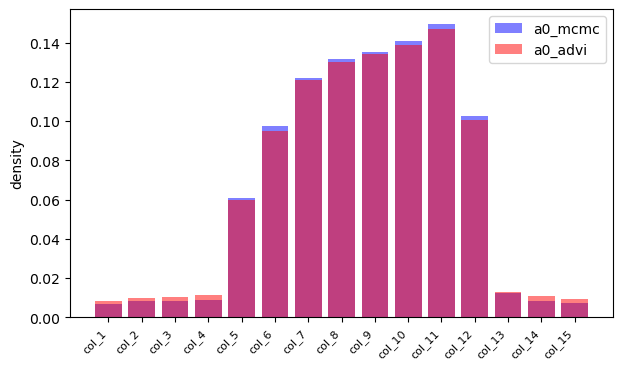

In [117]:
# ヒストグラムをプロット
plt.figure(figsize=(7,4))
plt.bar(X_cols, df_a0['alpha_normal'].values, color='blue', alpha=0.5, label='a0_mcmc')  # ヒストグラムを作成。binsはビンの数、alphaは透明度
plt.bar(X_cols, df_a0_advi['alpha_normal'].values, color='red', alpha=0.5, label='a0_advi')
# plt.xlabel('')  # x軸ラベル
plt.ylabel('density')  # y軸ラベル
plt.title('')  # グラフタイトル
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.legend()
plt.show()  # グラフを表示

ADVIでサンプリング数を１桁増やすと、MCMCと同様な結果が得られた